# BMES 543 Final Project
<p>Made By: 
<p>Daniel Thompson 
<p>Dhwanil Patel
<p>Radiyana Manchevan</p>
<p>Date: 5/28/22 </p>

# Imports
All python packages used for the project

In [2]:
%load_ext autoreload
%autoreload 2
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes

import pandas as pd
import re
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn import svm,metrics,feature_selection
from sklearn import ensemble
import random
import sklearn
from sklearn.model_selection import cross_val_score
import scikitplot as skplt
import pickle

PATH = os.path.join(bmes.tempdir(),"BMES543_crohns_project")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Executing command: C:\Users\Radiyana Mancheva\anaconda3\python.exe -m pip install -U scikitplot
ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot

FAILED to install scikitplot


ModuleNotFoundError: No module named 'scikitplot'

In [2]:
def sort_lex(df):
    # order cols in alphabetical order and place into df. return df
    
    f = df.columns
    return df.loc[:,sorted(f, key=str.upper)]

# Load Validation Dataset
There are less experimental groups than there are controls for the validation dataset. Will have 20 records total at the end... 10 exp 10 control for validation. 

In [3]:
val_df = pd.read_pickle(os.path.join(PATH,"validation_znorm.pkl"))
all_data_df = pd.read_pickle(os.path.join(PATH,"all_genes_znorm.pkl"))
sig_data_df = pd.read_pickle(os.path.join(PATH,"sig_genes_znorm.pkl"))

val_df_all = val_df.loc[val_df.index.isin(all_data_df.index)]

# needed for significant genes section
val_df_sig = val_df.loc[val_df.index.isin(sig_data_df.index)]

In [4]:
# all genes

val_final_df = val_df_all.T

e = val_final_df.filter(regex="E_*",axis=0).index.values.tolist()
c = val_final_df.filter(regex="C_*",axis=0).index.values.tolist()


rv = random.sample(range(len(c)), len(e))

map1 = [c[i] for i in rv] + e


val_final_df = val_final_df.loc[map1,:]
labels_val = np.array([1 if "C" in i else 0 for i in val_final_df.index])

# Models using feature selection 
Models Tested:
1. SVM - feature selection - validation set and drug set
2. Random Forrest - validation set 
3. Logistic Regression - feature selection - validation set


- 1=Control
- 0=Experimental


<p>Feature selection was also performed for the SVM</p>


## Load Data In 
Data is evenly split C vs E. C is the upper bound with 45 totoal records. E group is split accordingly

In [5]:
all_data_df = pd.read_pickle(os.path.join(PATH,"all_genes_znorm.pkl"))

final_df = all_data_df.T
final_df_all3_genes = final_df.copy()

e = final_df.filter(regex="E_*",axis=0).index.values.tolist()
c = final_df.filter(regex="C_*",axis=0).index.values.tolist()

# rv = [random.randint(0, len(e)-1) for i in range(len(c))]

rv = random.sample(range(len(e)), len(c))

map1 = [e[i] for i in rv] + c
final_df = final_df.loc[map1,:]

labels = np.array([1 if "C" in i else 0 for i in final_df.index])


# training dataset
X_train = final_df
f = X_train.columns
X_train = X_train.loc[:,sorted(f, key=str.upper)]

y_train = labels

# validation dataset
X_test = val_final_df
f = X_test.columns
X_test = X_test.loc[:,sorted(f, key=str.upper)]

y_test = labels_val

# # split data
# X_train, X_test, y_train, y_test = train_test_split(final_df, labels, test_size=0.30)

# print("Train/Test Sizes : ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## Drug Validation Set W8
using shared genes
- drug_w8_df_allgene
- labels_drug_w8

In [6]:
# import data
if not os.path.exists(os.path.join(PATH,"val_drug_w8_df.pkl")):
    
    df_pheno_GSE112366 = pd.read_pickle(os.path.join(PATH,"GSE112366_phenotype_data.pkl"))
    df_data_GSE112366 = pd.read_pickle(os.path.join(PATH,"GSE112366_data.pkl"))
    df_gpl_GSE112366 = pd.read_pickle(os.path.join(PATH,"GPL_GSE112366_data.pkl"))
    df_data_GSE112366.set_index('ID_REF',inplace=True)

    w8df = pd.read_pickle("./wk8pickle.pkl")
    W8_responders = w8df[w8df['characteristics_ch1.6.i-wk8 response'] == "Y"]
    W8_nonresponders = w8df[w8df['characteristics_ch1.6.i-wk8 response'] == "N"]

    w8_pulled = df_data_GSE112366.loc[:,df_data_GSE112366.columns.isin(w8df.index)]



    # label data with gene symbols
    genes = []
    probe_dict = {}

    for i,r in enumerate(df_gpl_GSE112366["ID"]):
        probe_dict[r] = df_gpl_GSE112366.loc[i,"Gene Symbol"]


    for i in w8_pulled.index: # data.index
        genes.append(probe_dict[i])

    w8_pulled["gene"] = genes # data

    # add to others
    w8_pulled.dropna(subset=['gene'],inplace=True)
    w8_pulled.set_index('gene',inplace=True)

    dup_genes = w8_pulled.loc[w8_pulled.index.duplicated(),:].index.values
    w8_pulled_copy = w8_pulled.copy()
    i = 0
    for g in dup_genes:

        eu = w8_pulled_copy.loc[w8_pulled_copy.index == g,:].mean()
        w8_pulled_copy.drop(index=g,inplace=True)
        w8_pulled_copy.loc[g] = eu.values

    new_genes =[i.upper().replace(" ","").replace("-","") for i in w8_pulled_copy.index]
    w8_pulled_copy.index = new_genes


    # label data for groups
    # drug response is healthy
    new_col = []
    for i,a in enumerate(w8_pulled_copy.columns.isin(W8_responders.index).tolist()):
        if a:
            new_col.append("H_"+str(i))
        else:
            new_col.append("D_"+str(i))

    # save data
    w8_pulled_copy2 = w8_pulled_copy.copy()
    w8_pulled_copy2.columns = new_col
    norm_gsedata = w8_pulled_copy2.apply(lambda x: (x - np.mean(x)) /np.std(x) )
    norm_gsedata.to_pickle(os.path.join(PATH,"val_drug_w8_df.pkl"))

else: 
    norm_gsedata = pd.read_pickle(os.path.join(PATH,"val_drug_w8_df.pkl"))


# getting genes of interest and creating ML labels
labels_drug_w8 = np.array([1 if "H" in i else 0 for i in norm_gsedata.columns])
drug_w8_df_allgene = norm_gsedata.loc[norm_gsedata.index.isin(all_data_df.index),:].T

f = drug_w8_df_allgene.columns
drug_w8_df_allgene = drug_w8_df_allgene.loc[:,sorted(f, key=str.upper)]

## Drug Validation Set W44
using shared genes
- labels_drug_w44
- drug_w44_df_allgene

In [7]:
# import data
if not os.path.exists(os.path.join(PATH,"val_drug_w44_df.pkl")):
    
    df_pheno_GSE112366 = pd.read_pickle(os.path.join(PATH,"GSE112366_phenotype_data.pkl"))
    df_data_GSE112366 = pd.read_pickle(os.path.join(PATH,"GSE112366_data.pkl"))
    df_gpl_GSE112366 = pd.read_pickle(os.path.join(PATH,"GPL_GSE112366_data.pkl"))
    df_data_GSE112366.set_index('ID_REF',inplace=True)

    w44df = pd.read_pickle("./wk44pickle.pkl")
    W44_responders = w44df[w44df['characteristics_ch1.6.i-wk8 response'] == "Y"]
    W44_nonresponders = w44df[w44df['characteristics_ch1.6.i-wk8 response'] == "N"]

    w44_pulled = df_data_GSE112366.loc[:,df_data_GSE112366.columns.isin(w44df.index)]


    genes = []
    probe_dict = {}

    for i,r in enumerate(df_gpl_GSE112366["ID"]):
        probe_dict[r] = df_gpl_GSE112366.loc[i,"Gene Symbol"]


    for i in w44_pulled.index: # data.index
        genes.append(probe_dict[i])

    w44_pulled["gene"] = genes # data

    # add to others
    w44_pulled.dropna(subset=['gene'],inplace=True)
    w44_pulled.set_index('gene',inplace=True)

    dup_genes = w44_pulled.loc[w44_pulled.index.duplicated(),:].index.values
    w44_pulled_copy = w44_pulled.copy()
    i = 0
    for g in dup_genes:

        eu = w44_pulled_copy.loc[w44_pulled_copy.index == g,:].mean()
        w44_pulled_copy.drop(index=g,inplace=True)
        w44_pulled_copy.loc[g] = eu.values

    new_genes =[i.upper().replace(" ","").replace("-","") for i in w44_pulled_copy.index]
    w44_pulled_copy.index = new_genes

    # response is healthy
    new_col = []
    for i,a in enumerate(w44_pulled_copy.columns.isin(W44_responders.index).tolist()):
        if a:
            new_col.append("H_"+str(i))
        else:
            new_col.append("D_"+str(i))


    w44_pulled_copy2 = w44_pulled_copy.copy()

    w44_pulled_copy2.columns = new_col
    norm_gsedata = w44_pulled_copy2.apply(lambda x: (x - np.mean(x)) /np.std(x) )
    norm_gsedata.to_pickle(os.path.join(PATH,"val_drug_w44_df.pkl"))

else:
    
    norm_gsedata = pd.read_pickle(os.path.join(PATH,"val_drug_w44_df.pkl"))
    

labels_drug_w44 = np.array([1 if "H" in i else 0 for i in norm_gsedata.columns])
drug_w44_df_allgene = norm_gsedata.loc[norm_gsedata.index.isin(all_data_df.index),:].T

f = drug_w44_df_allgene.columns
drug_w44_df_allgene = drug_w44_df_allgene.loc[:,sorted(f, key=str.upper)]

## SVM

Cross Validation Accuracy: 0.7642857142857142
Accuracy: 0.7


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

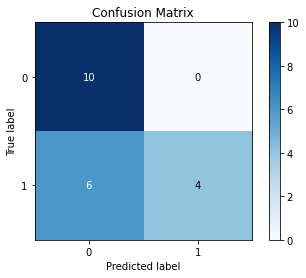

In [35]:
# create model
clf = svm.SVC(kernel='linear', C=1, random_state=42)
clf.fit(X_train, y_train)

svm_all_cvscore = cross_val_score(clf, X_train, y_train, cv=10)

print("Cross Validation Accuracy:",svm_all_cvscore.mean())

# test model

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

# save the model
# fn = 'SVM_allgenes.sav'
# pickle.dump(clf, open(fn, 'wb'))

### Predict Drug Interaction

Accuracy: 0.5378787878787878
Accuracy: 0.5617977528089888


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

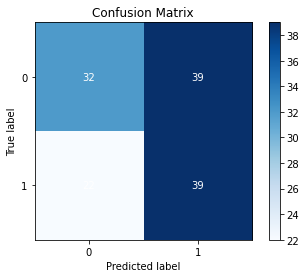

<Figure size 1080x432 with 0 Axes>

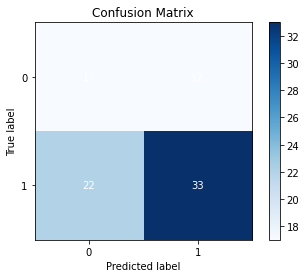

In [36]:
y_pred = clf.predict(drug_w8_df_allgene)
print("Accuracy:",metrics.accuracy_score(labels_drug_w8, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w8, y_pred,title="Confusion Matrix")


y_pred = clf.predict(drug_w44_df_allgene)
print("Accuracy:",metrics.accuracy_score(labels_drug_w44, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w44, y_pred,title="Confusion Matrix")

### Feature selection 

In [38]:
sfs = feature_selection.SequentialFeatureSelector(svm.SVC(),cv=10,direction='forward',scoring='accuracy')
res = sfs.fit(final_df, labels)

print("Name of genes that give best prediction results")
print(res.get_feature_names_out())


# df with the best genes to use determined by SequentialFeatureSelector
new_df_feature_selection = final_df.loc[:,final_df.columns.isin( res.get_feature_names_out())].copy()
f = new_df_feature_selection.columns
new_df_feature_selection = new_df_feature_selection.loc[:,sorted(f, key=str.upper)]


# create model and get cross validation scores
clf = svm.SVC()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, new_df_feature_selection, labels, cv=10,scoring="accuracy")

print()
# print accuracy average
print("Average Accuracy: {:.03}%".format(scores.mean()*100))
print()
num_sig_genes = len(final_df.columns.tolist())
print("{} original genes in dataframe".format(num_sig_genes))
print("{} significant genes were found in Feature Selection".format(len(res.get_feature_names_out().tolist())))


print("Features from SVM using feature selection compared to significant genes expressed between 2 GSE")

print()

for g in res.get_feature_names_out():
    print(g)

Name of genes that give best prediction results
['GAPDH' 'RARRES1' 'BTNL8' 'MMP9' 'FABP1' 'APOB' 'RPL4' 'TCL1A' 'RPL38'
 'RBP2' 'IL1B' 'CXCL9' 'TMSB10' 'ANXA10' 'SH3BGRL3' 'FCGBP' 'NOS2' 'RPS20'
 'LCT' 'MTTP' 'SPARCL1' 'PRR15L' 'RPS11' 'ADAMDEC1' 'FAM3B' 'SLC5A1'
 'REG3G' 'DDC' 'CD163' 'MYO1A' 'SPINK1' 'LGALS2' 'HEPACAM2' 'GZMA'
 'TSPAN8' 'S100A8' 'SLC10A2' 'FAM151A' 'LCN2' 'CPO' 'CYP3A4' 'SMOC2'
 'PNLIPRP2' 'ADH1C' 'PFN1' 'HLAA' 'GCNT3' 'FOLH1' 'CD63' 'CEACAM6']

Average Accuracy: 83.8%

100 original genes in dataframe
50 significant genes were found in Feature Selection
Features from SVM using feature selection compared to significant genes expressed between 2 GSE

GAPDH
RARRES1
BTNL8
MMP9
FABP1
APOB
RPL4
TCL1A
RPL38
RBP2
IL1B
CXCL9
TMSB10
ANXA10
SH3BGRL3
FCGBP
NOS2
RPS20
LCT
MTTP
SPARCL1
PRR15L
RPS11
ADAMDEC1
FAM3B
SLC5A1
REG3G
DDC
CD163
MYO1A
SPINK1
LGALS2
HEPACAM2
GZMA
TSPAN8
S100A8
SLC10A2
FAM151A
LCN2
CPO
CYP3A4
SMOC2
PNLIPRP2
ADH1C
PFN1
HLAA
GCNT3
FOLH1
CD63
CEACAM6


In [39]:
res.get_feature_names_out()

array(['GAPDH', 'RARRES1', 'BTNL8', 'MMP9', 'FABP1', 'APOB', 'RPL4',
       'TCL1A', 'RPL38', 'RBP2', 'IL1B', 'CXCL9', 'TMSB10', 'ANXA10',
       'SH3BGRL3', 'FCGBP', 'NOS2', 'RPS20', 'LCT', 'MTTP', 'SPARCL1',
       'PRR15L', 'RPS11', 'ADAMDEC1', 'FAM3B', 'SLC5A1', 'REG3G', 'DDC',
       'CD163', 'MYO1A', 'SPINK1', 'LGALS2', 'HEPACAM2', 'GZMA', 'TSPAN8',
       'S100A8', 'SLC10A2', 'FAM151A', 'LCN2', 'CPO', 'CYP3A4', 'SMOC2',
       'PNLIPRP2', 'ADH1C', 'PFN1', 'HLAA', 'GCNT3', 'FOLH1', 'CD63',
       'CEACAM6'], dtype=object)

Accuracy: 0.5


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

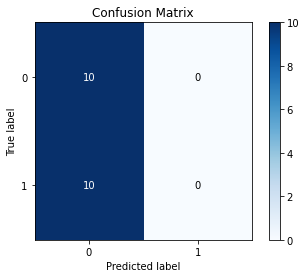

In [45]:

clf.fit(new_df_feature_selection,labels)

new_X_test = X_test.loc[:,X_test.columns.isin(new_df_feature_selection.columns)]
f = new_X_test.columns
new_X_test = new_X_test.loc[:,sorted(f, key=str.upper)]

y_pred = clf.predict(new_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

### Drug Interaction 

Accuracy: 0.5075757575757576
Accuracy: 0.5393258426966292


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

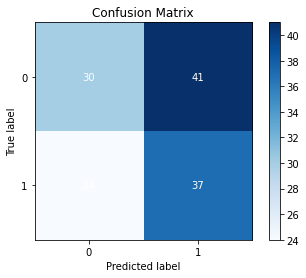

<Figure size 1080x432 with 0 Axes>

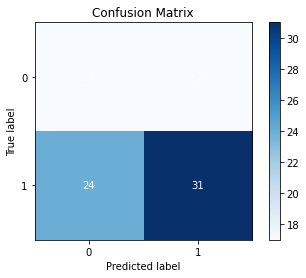

In [46]:
w8df_copy = sort_lex(drug_w8_df_allgene)
w8df_copy = w8df_copy.loc[:,w8df_copy.columns.isin(new_df_feature_selection.columns)]

y_pred = clf.predict(w8df_copy)
print("Accuracy:",metrics.accuracy_score(labels_drug_w8, y_pred))
fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w8, y_pred,title="Confusion Matrix")

#-----------


w44df_copy = sort_lex(drug_w44_df_allgene)
w44df_copy = w44df_copy.loc[:,w44df_copy.columns.isin(new_df_feature_selection.columns)]

y_pred = clf.predict(w44df_copy)
print("Accuracy:",metrics.accuracy_score(labels_drug_w44, y_pred))
fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w44, y_pred,title="Confusion Matrix")

## Random Forrest

Cross Validation Accuracy: 0.7595238095238095
Accuracy: 0.8


<Figure size 1080x432 with 0 Axes>

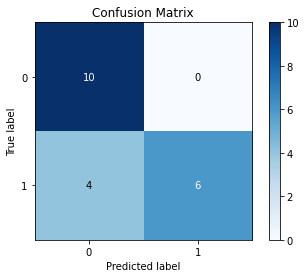

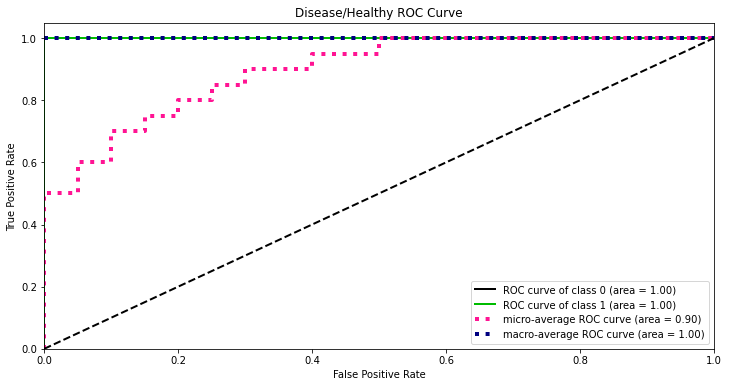

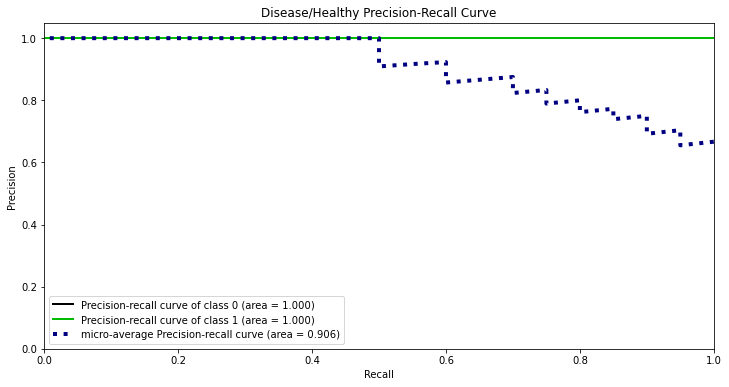

In [8]:
randomforrest = ensemble.RandomForestClassifier(max_depth=5)

randomforrest.fit(X_train, y_train)


# test model
y_pred = randomforrest.predict(X_test)

rf_all_cvscore =  cross_val_score(randomforrest, X_train, y_train, cv=10)

print("Cross Validation Accuracy:",rf_all_cvscore.mean())

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))




fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

Y_test_probs = randomforrest.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, Y_test_probs,
                       title="Disease/Healthy ROC Curve", figsize=(12,6));

skplt.metrics.plot_precision_recall(y_test, Y_test_probs,
                       title="Disease/Healthy Precision-Recall Curve", figsize=(12,6));

# save the model
# fn = 'RF_allgenes.sav'
# pickle.dump(randomforrest, open(fn, 'wb'))

Elapsed time to compute the importances: 0.013 seconds


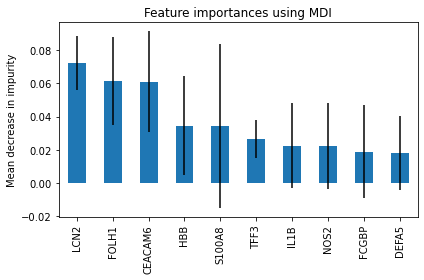

In [9]:
# taken from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import time

start_time = time.time()
importances = randomforrest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforrest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


feature_names = X_train.columns.tolist()

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)

forest_importances = forest_importances[:10]
std = std[:10]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Accuracy: 0.5757575757575758
Accuracy: 0.48314606741573035


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

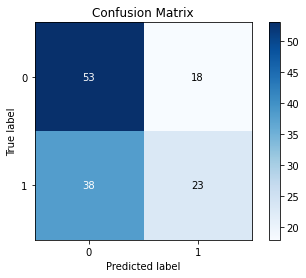

<Figure size 1080x432 with 0 Axes>

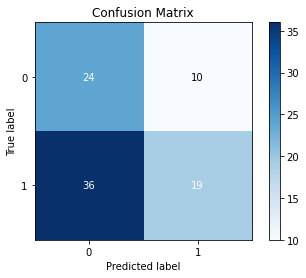

In [49]:
# drug
y_pred = randomforrest.predict(drug_w8_df_allgene)
print("Accuracy:",metrics.accuracy_score(labels_drug_w8, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w8, y_pred,title="Confusion Matrix")


y_pred = randomforrest.predict(drug_w44_df_allgene)
print("Accuracy:",metrics.accuracy_score(labels_drug_w44, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w44, y_pred,title="Confusion Matrix")

## Linear Model

Cross Validation Accuracy: 0.8071428571428572
Accuracy: 0.6


<Figure size 1080x432 with 0 Axes>

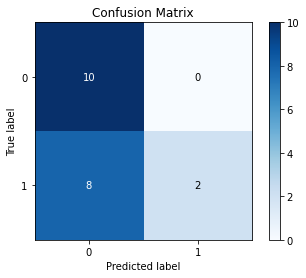

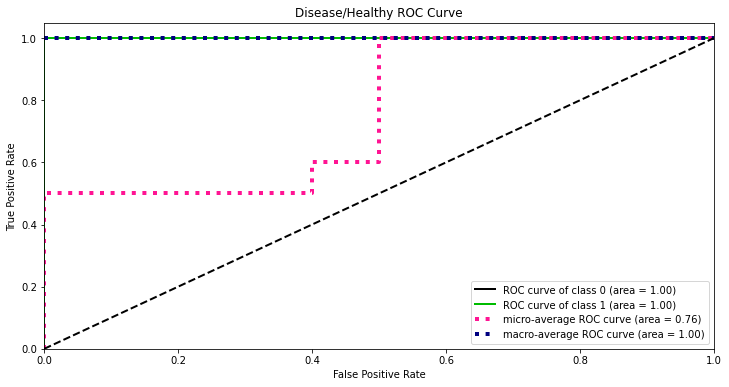

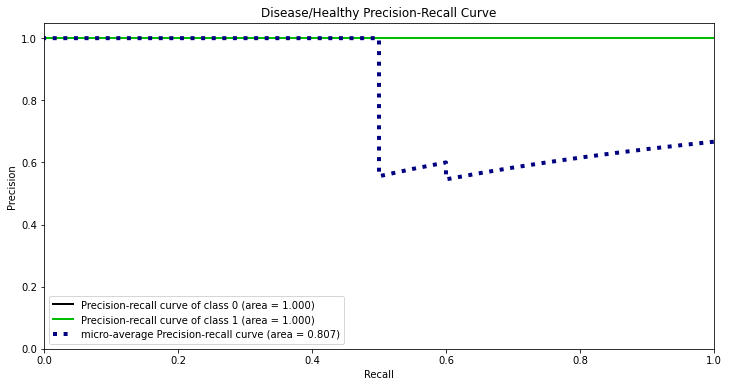

In [50]:
import sklearn
linearmodel = sklearn.linear_model.LogisticRegression(max_iter=1000)


# train
linearmodel.fit(X_train, y_train)


# test model
y_pred = linearmodel.predict(X_test)

lr_all_cvscore =  cross_val_score(linearmodel, X_train, y_train, cv=10)

print("Cross Validation Accuracy:",lr_all_cvscore.mean())

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

Y_test_probs = linearmodel.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, Y_test_probs,
                       title="Disease/Healthy ROC Curve", figsize=(12,6));

skplt.metrics.plot_precision_recall(y_test, Y_test_probs,
                       title="Disease/Healthy Precision-Recall Curve", figsize=(12,6));

# save the model
# fn = 'linearmodel_allgenes.sav'
# pickle.dump(linearmodel, open(fn, 'wb'))

Accuracy: 0.5757575757575758
Accuracy: 0.5280898876404494


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

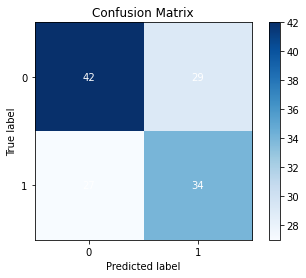

<Figure size 1080x432 with 0 Axes>

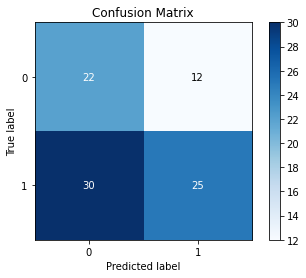

In [51]:
# drug without feature selection 
y_pred = linearmodel.predict(drug_w8_df_allgene)
print("Accuracy:",metrics.accuracy_score(labels_drug_w8, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w8, y_pred,title="Confusion Matrix")


y_pred = linearmodel.predict(drug_w44_df_allgene)
print("Accuracy:",metrics.accuracy_score(labels_drug_w44, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w44, y_pred,title="Confusion Matrix")

In [52]:
linearmodel = sklearn.linear_model.LogisticRegression(max_iter=1000)

sfs = feature_selection.SequentialFeatureSelector(linearmodel,cv=10,direction='forward',scoring='accuracy')
res = sfs.fit(final_df, labels)

print("Name of genes that give best prediction results")
print(res.get_feature_names_out())


# df with the best genes to use determined by SequentialFeatureSelector
new_df_feature_selection = final_df.loc[:,final_df.columns.isin( res.get_feature_names_out())].copy()
f = new_df_feature_selection.columns
new_df_feature_selection = new_df_feature_selection.loc[:,sorted(f, key=str.upper)]


# create model and get cross validation scores
linearmodel.fit(X_train, y_train)
scores = cross_val_score(linearmodel, new_df_feature_selection, labels, cv=10,scoring="accuracy")

print()
# print accuracy average
print("Average Accuracy: {:.03}%".format(scores.mean()*100))
print()
num_sig_genes = len(final_df.columns.tolist())
print("{} original genes in dataframe".format(num_sig_genes))
print("{} significant genes were found in Feature Selection".format(len(res.get_feature_names_out().tolist())))


print("Features from SVM using feature selection compared to significant genes expressed between 2 GSE")

print()

for g in res.get_feature_names_out():
    print(g)

Name of genes that give best prediction results
['GAPDH' 'RARRES1' 'BTNL8' 'MMP9' 'APOB' 'RPL4' 'CYP3A7' 'RPL38' 'IL1B'
 'CXCL9' 'TMSB10' 'ANXA10' 'SH3BGRL3' 'FCGBP' 'NOS2' 'RPS20' 'LCT'
 'SPARCL1' 'PRR15L' 'RPS11' 'ADAMDEC1' 'CD163' 'MEP1B' 'TSPAN8' 'GATM'
 'SLC3A1' 'LCN2' 'REG1A' 'CYP3A4' 'PFN1' 'EIF3L' 'RPL14' 'HLAA' 'GCNT3'
 'RPL30' 'ACTB' 'UBA52' 'TPT1' 'FOLH1' 'RPS3' 'RPL13A' 'TFF3' 'UBC'
 'NEAT1' 'FTL' 'RPL22' 'RPL3' 'MMP12' 'MALAT1' 'HSPA8']

Average Accuracy: 86.7%

100 original genes in dataframe
50 significant genes were found in Feature Selection
Features from SVM using feature selection compared to significant genes expressed between 2 GSE

GAPDH
RARRES1
BTNL8
MMP9
APOB
RPL4
CYP3A7
RPL38
IL1B
CXCL9
TMSB10
ANXA10
SH3BGRL3
FCGBP
NOS2
RPS20
LCT
SPARCL1
PRR15L
RPS11
ADAMDEC1
CD163
MEP1B
TSPAN8
GATM
SLC3A1
LCN2
REG1A
CYP3A4
PFN1
EIF3L
RPL14
HLAA
GCNT3
RPL30
ACTB
UBA52
TPT1
FOLH1
RPS3
RPL13A
TFF3
UBC
NEAT1
FTL
RPL22
RPL3
MMP12
MALAT1
HSPA8


Accuracy: 0.8


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

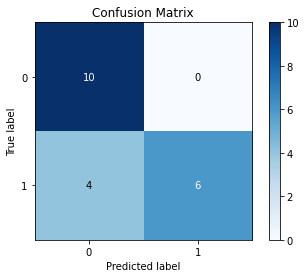

In [53]:
linearmodel.fit(new_df_feature_selection,labels)

new_X_test = X_test.loc[:,X_test.columns.isin(new_df_feature_selection.columns)]
f = new_X_test.columns
new_X_test = new_X_test.loc[:,sorted(f, key=str.upper)]

y_pred = linearmodel.predict(new_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

Accuracy: 0.5681818181818182
Accuracy: 0.4943820224719101


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

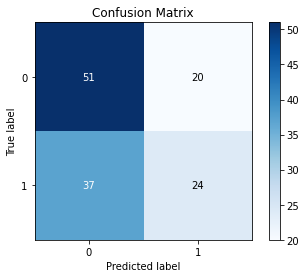

<Figure size 1080x432 with 0 Axes>

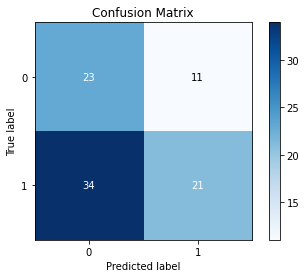

In [55]:
w8df_copy = sort_lex(drug_w8_df_allgene)
w8df_copy = w8df_copy.loc[:,w8df_copy.columns.isin(new_df_feature_selection.columns)]

y_pred = linearmodel.predict(w8df_copy)
print("Accuracy:",metrics.accuracy_score(labels_drug_w8, y_pred))
fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w8, y_pred,title="Confusion Matrix")

#-----------


w44df_copy = sort_lex(drug_w44_df_allgene)
w44df_copy = w44df_copy.loc[:,w44df_copy.columns.isin(new_df_feature_selection.columns)]

y_pred = linearmodel.predict(w44df_copy)
print("Accuracy:",metrics.accuracy_score(labels_drug_w44, y_pred))
fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(labels_drug_w44, y_pred,title="Confusion Matrix")

# Model using Sig Genes
Models Tested:
1. SVM
2. Random Forrest
3. Logistic Regression


## Load Data In 

In [26]:
val_final_df = val_df_sig.T

e = val_final_df.filter(regex="E_*",axis=0).index.values.tolist()
c = val_final_df.filter(regex="C_*",axis=0).index.values.tolist()

# rv = [random.randint(0, len(e)-1) for i in range(len(c))]

rv = random.sample(range(len(c)), len(e))

map1 = [c[i] for i in rv] + e
val_final_df = val_final_df.loc[map1,:]

labels_val = np.array([1 if "C" in i else 0 for i in val_final_df.index])

In [27]:
all_data_df = pd.read_pickle(os.path.join(PATH,"sig_genes_znorm.pkl"))
final_df = all_data_df.T
final_df_sig_genes = final_df.copy()

e = final_df.filter(regex="E_*",axis=0).index.values.tolist()
c = final_df.filter(regex="C_*",axis=0).index.values.tolist()

# rv = [random.randint(0, len(e)-1) for i in range(len(c))]

# # random splitting of data based off how many controls there are
rv = random.sample(range(len(e)), len(c))
map1 = [e[i] for i in rv] + c
final_df = final_df.loc[map1,:]

labels = [1 if "C" in i else 0 for i in final_df.index]

# training dataset
X_train = final_df
f = X_train.columns
X_train = X_train.loc[:,sorted(f, key=str.upper)]

y_train = labels

# validation dataset
X_test = val_final_df
f = X_test.columns
X_test = X_test.loc[:,sorted(f, key=str.upper)]

y_test = labels_val


# # split data
# X_train, X_test, y_train, y_test = train_test_split(final_df, labels, test_size=0.30)
# print("Train/Test Sizes : ",X_train.shape, X_test.shape, len(y_train), len(y_test))

In [28]:
# for i in final_df.columns:
#     print(i)

# final_df.columns

## SVM

Cross Validation Accuracy: 0.8690476190476192
Accuracy: 0.5


<Figure size 1080x432 with 0 Axes>

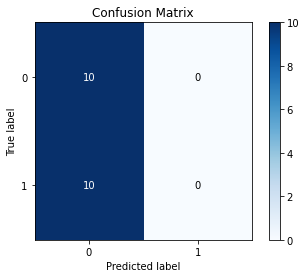

In [29]:
# create model
clf1 = svm.SVC()
clf1.fit(X_train, y_train)

# test model
y_pred = clf1.predict(X_test)

svm_sig_cvscore =  cross_val_score(clf1, X_train, y_train, cv=10)

print("Cross Validation Accuracy:",svm_sig_cvscore.mean())

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")


assert sum(X_train.columns == X_test.columns)  == 82
# # save the model
# fn = 'SVM_siggene.sav'
# pickle.dump(clf1, open(fn, 'wb'))

In [10]:
# feature selection 

clf1 = svm.SVC()


sfs = feature_selection.SequentialFeatureSelector(clf1,cv=10,direction='forward',scoring='accuracy')
res = sfs.fit(final_df, labels)

print("Name of genes that give best prediction results")
print(res.get_feature_names_out())


# df with the best genes to use determined by SequentialFeatureSelector
new_df_feature_selection = final_df.loc[:,final_df.columns.isin( res.get_feature_names_out())].copy()
f = new_df_feature_selection.columns
new_df_feature_selection = new_df_feature_selection.loc[:,sorted(f, key=str.upper)]


# create model and get cross validation scores
clf1.fit(X_train, y_train)
scores = cross_val_score(clf1, new_df_feature_selection, labels, cv=10,scoring="accuracy")

print()
# print accuracy average
print("Average Accuracy: {:.03}%".format(scores.mean()*100))
print()
num_sig_genes = len(final_df.columns.tolist())
print("{} original genes in dataframe".format(num_sig_genes))
print("{} significant genes were found in Feature Selection".format(len(res.get_feature_names_out().tolist())))


print("Features from SVM using feature selection compared to significant genes expressed between 2 GSE")

print()

for g in res.get_feature_names_out():
    print(g)



Name of genes that give best prediction results
['SAMD9L' 'IRF1' 'FPR1' 'TLR2' 'GSTA1' 'NPY' 'GUCA2B' 'IDO1' 'CXCL6'
 'NOS2' 'VPREB3' 'LILRB2' 'CXCL10' 'TC2N' 'PSMB8' 'CRIP1' 'GBP5' 'GSTA3'
 'DPEP1' 'MXRA5' 'CARD6' 'CLDN2' 'ANO5' 'CCL11' 'NCF2' 'FBXO6' 'BTN3A3'
 'CD19' 'PLA2G7' 'LRG1' 'NAT8B' 'PYY' 'ANKRD22' 'RHOBTB2' 'HOXA5' 'CD14'
 'LCN2' 'KCNE3' 'GBP1' 'COL4A1' 'FOLH1']

Average Accuracy: 92.6%

82 original genes in dataframe
41 significant genes were found in Feature Selection
Features from SVM using feature selection compared to significant genes expressed between 2 GSE

SAMD9L
IRF1
FPR1
TLR2
GSTA1
NPY
GUCA2B
IDO1
CXCL6
NOS2
VPREB3
LILRB2
CXCL10
TC2N
PSMB8
CRIP1
GBP5
GSTA3
DPEP1
MXRA5
CARD6
CLDN2
ANO5
CCL11
NCF2
FBXO6
BTN3A3
CD19
PLA2G7
LRG1
NAT8B
PYY
ANKRD22
RHOBTB2
HOXA5
CD14
LCN2
KCNE3
GBP1
COL4A1
FOLH1


Accuracy: 0.95


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

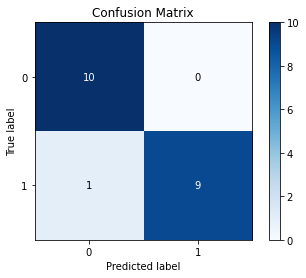

In [11]:
clf1.fit(new_df_feature_selection,labels)

new_X_test = X_test.loc[:,X_test.columns.isin(new_df_feature_selection.columns)]
f = new_X_test.columns
new_X_test = new_X_test.loc[:,sorted(f, key=str.upper)]

y_pred = clf1.predict(new_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

## Random Forrest

Cross Validation Accuracy: 0.8666666666666666
Accuracy: 0.7


<Figure size 1080x432 with 0 Axes>

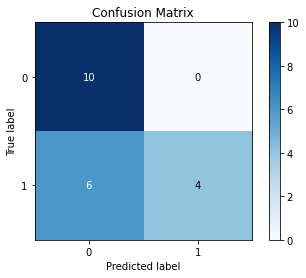

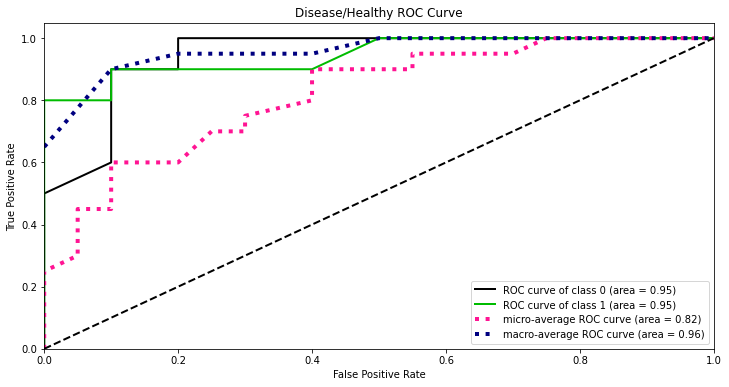

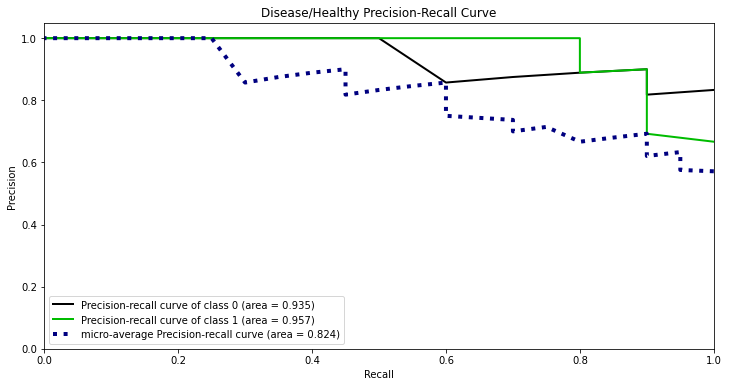

In [12]:
randomforrest = ensemble.RandomForestClassifier(max_depth=5)

randomforrest.fit(X_train, y_train)


# test model
y_pred = randomforrest.predict(X_test)

rf_sig_cvscore =  cross_val_score(randomforrest, X_train, y_train, cv=10)

print("Cross Validation Accuracy:",rf_sig_cvscore.mean())

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))




fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

Y_test_probs = randomforrest.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, Y_test_probs,
                       title="Disease/Healthy ROC Curve", figsize=(12,6));

skplt.metrics.plot_precision_recall(y_test, Y_test_probs,
                       title="Disease/Healthy Precision-Recall Curve", figsize=(12,6));

assert sum(X_train.columns == X_test.columns)  == 82

# save the model
# fn = 'RF_siggene.sav'
# pickle.dump(randomforrest, open(fn, 'wb'))

In [13]:
y_pred = randomforrest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7


Elapsed time to compute the importances: 0.014 seconds


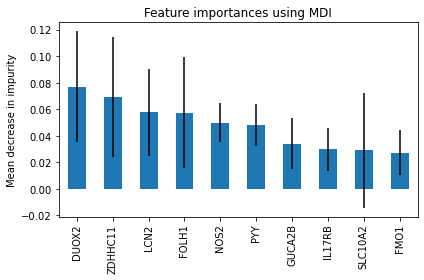

In [14]:
# taken from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import time

start_time = time.time()
importances = randomforrest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforrest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


feature_names = X_train.columns.tolist()

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)

forest_importances = forest_importances[:10]
std = std[:10]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Logistic Regression

Cross Validation Accuracy: 0.8785714285714284
Accuracy: 0.7


<Figure size 1080x432 with 0 Axes>

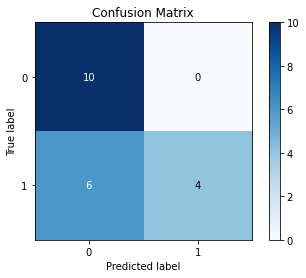

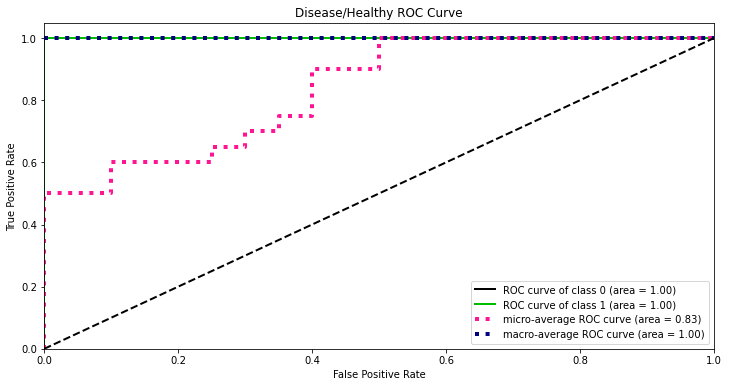

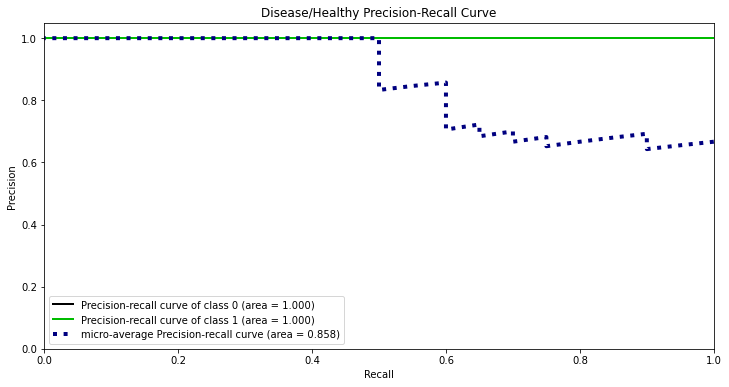

In [18]:
linearmodel = sklearn.linear_model.LogisticRegression()


# train
linearmodel.fit(X_train, y_train)


# test model
y_pred = linearmodel.predict(X_test)

lr_sig_cvscore =  cross_val_score(linearmodel, X_train, y_train, cv=10)

print("Cross Validation Accuracy:",lr_sig_cvscore.mean())

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")

Y_test_probs = linearmodel.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, Y_test_probs,
                       title="Disease/Healthy ROC Curve", figsize=(12,6));

skplt.metrics.plot_precision_recall(y_test, Y_test_probs,
                       title="Disease/Healthy Precision-Recall Curve", figsize=(12,6));


assert sum(X_train.columns == X_test.columns)  == 82

# save the model
# fn = 'LR_siggene.sav'
# pickle.dump(linearmodel, open(fn, 'wb'))

In [19]:
# feature selection 

linearmodel = sklearn.linear_model.LogisticRegression()


sfs = feature_selection.SequentialFeatureSelector(linearmodel,cv=10,direction='forward',scoring='accuracy')
res = sfs.fit(final_df, labels)

print("Name of genes that give best prediction results")
print(res.get_feature_names_out())


# df with the best genes to use determined by SequentialFeatureSelector
new_df_feature_selection = final_df.loc[:,final_df.columns.isin( res.get_feature_names_out())].copy()
f = new_df_feature_selection.columns
new_df_feature_selection = new_df_feature_selection.loc[:,sorted(f, key=str.upper)]


# create model and get cross validation scores
linearmodel.fit(X_train, y_train)
scores = cross_val_score(linearmodel, new_df_feature_selection, labels, cv=10,scoring="accuracy")

print()
# print accuracy average
print("Average Accuracy: {:.03}%".format(scores.mean()*100))
print()
num_sig_genes = len(final_df.columns.tolist())
print("{} original genes in dataframe".format(num_sig_genes))
print("{} significant genes were found in Feature Selection".format(len(res.get_feature_names_out().tolist())))


print("Features from SVM using feature selection compared to significant genes expressed between 2 GSE")

print()

for g in res.get_feature_names_out():
    print(g)



Name of genes that give best prediction results
['SAMD9L' 'IRF1' 'FPR1' 'TLR2' 'GSTA1' 'NPY' 'GUCA2B' 'IDO1' 'CXCL6'
 'NOS2' 'VPREB3' 'LILRB2' 'CXCL10' 'TC2N' 'CRIP1' 'GBP5' 'DPEP1' 'MXRA5'
 'CARD6' 'CLDN2' 'ANO5' 'KCNJ13' 'BTN3A3' 'LRG1' 'PYY' 'ANKRD22' 'PLAUR'
 'HOXA5' 'MUC1' 'CD14' 'KCNE3' 'IL17RB' 'GUCA2A' 'STAT1' 'GBP1' 'DUOX2'
 'GBP4' 'VWF' 'MRAP2' 'CASP10' 'CFI']

Average Accuracy: 91.2%

82 original genes in dataframe
41 significant genes were found in Feature Selection
Features from SVM using feature selection compared to significant genes expressed between 2 GSE

SAMD9L
IRF1
FPR1
TLR2
GSTA1
NPY
GUCA2B
IDO1
CXCL6
NOS2
VPREB3
LILRB2
CXCL10
TC2N
CRIP1
GBP5
DPEP1
MXRA5
CARD6
CLDN2
ANO5
KCNJ13
BTN3A3
LRG1
PYY
ANKRD22
PLAUR
HOXA5
MUC1
CD14
KCNE3
IL17RB
GUCA2A
STAT1
GBP1
DUOX2
GBP4
VWF
MRAP2
CASP10
CFI


Accuracy: 0.85


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 1080x432 with 0 Axes>

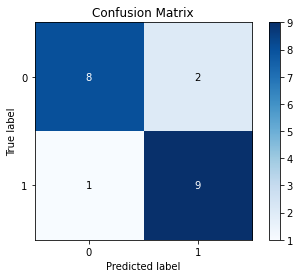

In [25]:
linearmodel.fit(new_df_feature_selection,labels)

new_X_test = X_test.loc[:,X_test.columns.isin(new_df_feature_selection.columns)]
f = new_X_test.columns
new_X_test = new_X_test.loc[:,sorted(f, key=str.upper)]

y_pred = linearmodel.predict(new_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(15,6))
skplt.metrics.plot_confusion_matrix(y_test, y_pred,title="Confusion Matrix")